In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import gridspec
import ast
import os
#os.chdir('/home/bojk/Data/') #this is when opened in '/home/bojk/Data/notebooks' on linux Quakelab
os.chdir('/Users/bojk/Google Drive/QuakeLab/Data/')
import sys
#sys.path.append('/home/bojk/Data/minimeta_pyfiles/')
sys.path.append('/Users/bojk/Google Drive/QuakeLab/minimeta_pyfiles/')
import imp
import HTSeq
from scipy.stats import powerlaw
#import minimetagenome_analysis as minimeta

import mock_metagenome_creation as mock
imp.reload(mock)
#import reassembly as rea
#import subcluster_bins as sub
#import checkm_out_plot as cop
#import checkm_out as co

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['legend.fontsize'] = 14

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#maindir = "Mock/Archaea_illuminaHS_low<20contigs/"
maindir = 'mock_metagenomes/'
kmerdf = pd.read_pickle(maindir+'stats/kmerdf__feb15.pickle')
contigdf = pd.read_pickle(maindir+'stats/contigdf__feb15.pickle')
statsdf = pd.read_pickle(maindir+'stats/statsdf__feb15.pickle')
tsne = pd.read_pickle(maindir+'stats/tsne_normalized_scaled_5mers_perp40.pickle')

kmerdf_norm = kmerdf.divide(contigdf['Sequence length'],axis=0)
kmer_pergenome = kmerdf_norm.join(tsne.genome).groupby('genome').sum()
kmer_pergenome = kmer_pergenome.divide(statsdf['frag_contigs'],axis=0)
# add genome-wide kmer variance to statsdf (normalized to genome with max variance)
statsdf['kmer_variance'] = kmer_pergenome.var(axis=1).divide(kmer_pergenome.var(axis=1).max())

In [3]:
#meta = pd.read_pickle('Permafrost/FranklinBluffs/pickles/maindf_withDepth')
#data = list(meta['Sequence Length'])
numbins = 100
bootstrap = 500
bins = np.logspace(3,6,numbins)
#counts, bin_edges = np.histogram(data,bins=bins)
bin_edges = bins

In [4]:
low_var_genome = statsdf[statsdf['kmer_variance']==statsdf['kmer_variance'].min()].index[0]
high_var_genome = statsdf[statsdf['kmer_variance']==statsdf['kmer_variance'].max()].index[0]
f,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(tsne[0],tsne[1],s=tsne['Sequence length'].astype(float)/100,alpha=.05,c=tsne['GC'],cmap='RdBu_r')
f.savefig(maindir+'plots/tSNE_GC_5mer_feb_15.png')

In [5]:
x = StandardScaler().fit_transform(kmerdf_norm)
pca = PCA(n_components=100)
principalComp = pca.fit_transform(x)
princdf = pd.DataFrame(principalComp)
princdf.index =tsne.index

In [134]:
from sklearn.metrics.pairwise import euclidean_distances

def make_QCdf_from_tsnedf(tsnedf,maindir,savename):
    QC_df = pd.DataFrame(index=tsnedf.genome.unique(),columns=['total_distance','num_contigs'])
    for binn in QC_df.index:
        X = tsnedf[tsnedf.genome==binn][[0,1]]
        dist = euclidean_distances(X,X)
        distdf = pd.DataFrame(dist)
        medist = pd.DataFrame(index=range(len(dist)),columns=['medx','medy'])
        medist['medx']=X[0].median() #this is to compute distance to median
        medist['medy']=X[1].median()
        QC_df.loc[binn,'median_x'] = X[0].median()
        QC_df.loc[binn,'median_y'] = X[1].median()
        QC_df.loc[binn,'mean_x'] = X[0].mean()
        QC_df.loc[binn,'mean_y'] = X[1].mean()
        QC_df.loc[binn,'R_median'] =  pd.DataFrame(euclidean_distances(X,medist[['medx','medy']]))[0].median()
        QC_df.loc[binn,'R_mean'] = pd.DataFrame(euclidean_distances(X,medist[['medx','medy']]))[0].mean()
        QC_df.loc[binn,'total_distance'] = distdf.sum().sum()/2
        QC_df.loc[binn,'num_contigs'] = len(distdf)
    maxdist = np.max(euclidean_distances(tsnedf[[0,1]],tsnedf[[0,1]]))
    QC_df['mean_dist'] = QC_df['total_distance'].divide(QC_df['num_contigs']**2/2)
    QC_df['norm_mean_dist'] = QC_df['mean_dist'].divide(maxdist)
    QC_df['dist_from_origin_mean'] = [f[0] for f in euclidean_distances(QC_df[['mean_x','mean_y']],[[0,0]])]
    QC_df['dist_from_origin_median'] = [f[0] for f in euclidean_distances(QC_df[['median_x','median_y']],[[0,0]])]
    maxdist_fromorigin = np.max(euclidean_distances(tsnedf[[0,1]],[[0,0]]))
    maxdist_fromorigin = QC_df['dist_from_origin_median'].max()
    QC_df['med_mean_diff'] = np.diagonal(euclidean_distances(QC_df[['median_x','median_y']],QC_df[['mean_x','mean_y']]))
    QC_df['frac_med_mean_diff'] = QC_df['med_mean_diff'].divide(maxdist_fromorigin)
    QC_df['frac_mean_orig'] = QC_df['dist_from_origin_mean'].divide(maxdist_fromorigin)
    QC_df['frac_median_orig'] = QC_df['dist_from_origin_median'].divide(maxdist_fromorigin)
    QC_df.to_pickle(maindir+'QCdf_'+savename+'.pickle')
    return(QC_df)

def circle(x,y,r):
    t = np.arange(0,2*np.pi,.01)
    cx = x+r*np.sin(t)
    cy = y+r*np.cos(t)
    return(cx,cy)

def plot_ground_truth_circles(tsne_df,QC_df,genome_ID,maindir,savename):
    info = QC_df.loc[genome_ID]
    x,y = circle(info['median_x'],info['median_y'],info['R_median'])
    x2,y2 = circle(info['median_x'],info['median_y'],info['R_mean'])
    f,ax = plt.subplots(figsize=(13,11))
    tsne_df[tsne_df.genome!=genome_ID].plot.scatter(0,1,alpha=.05,s=tsne_df['Sequence length'].astype(float).divide(2e2),c='gray',ax=ax,label=None)
    tsne_df[tsne_df.genome==genome_ID].plot.scatter(0,1,alpha=.2,s=tsne_df['Sequence length'].astype(float).divide(2e2),c='orange',ax=ax,label='genome '+genome_ID)
    plt.plot(info['median_x'],info['median_y'],'o',label='median contig pos')
    plt.plot(info['mean_x'],info['mean_y'],'or',label='mean contig pos')
    plt.plot(x,y,label='R=median dist')
    plt.plot(x2,y2,label='R=mean dist')
    plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right')
    plt.gcf().subplots_adjust(right=0.75)
    f.savefig(maindir+'plots/ground_truth_circles_'+genome_ID+'_'+savename+'.png')
    plt.close(f)
    
import imageio
import glob
def make_gif(image_path,save_name):
    #image_path = maindir+'plots/'
    #image_path = 'Permafrost/SagMAT/bins/fasta/originals/plots/'
    files = glob.glob(image_path+'*.png')
    files = np.sort(files)
    images = []
    for file in files:
        # imageio.imread(file) creates a numpy matrix array
        # In this case a 200 x 200 matrix for every file, since the files are 200 x 200 pixels.
        images.append(imageio.imread(file))
        print(file)
    imageio.mimsave(image_path+save_name+'.gif', images)
    
def plot_all_circles(tsne_df,QC_df,savedir,savename):
    f,ax = plt.subplots(figsize=(12,12))
    tsne_df.plot.scatter(0,1,alpha=.05,s=tsne_df['Sequence length'].astype(float).divide(2e2),
                         c='gray',ax=ax,label=None)
    plt.plot([QC_df['median_x'],QC_df['mean_x']],[QC_df['median_y'],QC_df['mean_y']],
             '-om',label='median contig pos')
    ax.plot(QC_df['median_x'],QC_df['median_y'],'o',label='median contig pos')
    ax.plot(QC_df['mean_x'],QC_df['mean_y'],'or',label='mean contig pos')
    for genome in QC_df.index:
        dat = QC_df.loc[genome]
        x,y = circle(dat['median_x'],dat['median_y'],dat['R_median'])
        x2,y2 = circle(dat['median_x'],dat['median_y'],dat['R_mean'])
        ax.plot(x,y,label='R=median dist',c='r')
        ax.plot(x2,y2,label='R=mean dist',c='b')
    f.savefig(savedir+savename+'_all_circles.png')
    
def plot_all_circles_thres(tsne_df,QC_df,thres,savedir,savename):
    QC_df['radrat'] = QC_df['R_median'].divide(QC_df['R_mean'])
    QC_df['thres'] = QC_df['frac_mean_orig']-QC_df['frac_med_mean_diff']
    indf = QC_df[QC_df.thres>=thres]
    oudf = QC_df[QC_df.thres<thres]
    f,ax = plt.subplots(figsize=(12,12))
    tsne_df.plot.scatter(0,1,alpha=.05,s=tsne_df['Sequence length'].astype(float).divide(2e2),
                         c='gray',ax=ax,label=None)
    #plt.plot([QC_df['median_x'],QC_df['mean_x']],[QC_df['median_y'],QC_df['mean_y']],
    #         '-om',label='median contig pos')
    ax.plot(QC_df['median_x'],QC_df['median_y'],'o',label='median contig pos')
    #ax.plot(QC_df['mean_x'],QC_df['mean_y'],'or',label='mean contig pos')
    for genome in QC_df.index:
        dat = QC_df.loc[genome]
        x,y = circle(dat['median_x'],dat['median_y'],dat['R_median'])
        x2,y2 = circle(dat['median_x'],dat['median_y'],dat['R_mean'])
        if genome in indf.index:
            ax.plot(x,y,label='R=median dist',c='r')
            ax.plot(x2,y2,label='R=mean dist',c='b')
        elif genome in oudf.index:
            ax.plot(x,y,label='R=median dist',c='gray')
            ax.plot(x2,y2,label='R=mean dist',c='gray')


        f.savefig(savedir+savename+'_all_circles_somethres.png')

In [52]:
genome = QC_general_tsne.index[0]
plot_ground_truth_circles(tsne,QC_general_tsne,genome,maindir,'main5mertSNE_15feb')

In [136]:
QC_general_tsne = make_QCdf_from_tsnedf(tsne,maindir,'main_tSNE_15feb')
tsnePCA100 = pd.read_pickle(maindir+'stats/tsnedf_15feb_PCA100.pickle')
QC_PCA100 = make_QCdf_from_tsnedf(tsnePCA100,maindir,'main_tSNE_15feb')

In [53]:
for genome in QC_general_tsne.index:
    plot_ground_truth_circles(tsne,QC_general_tsne,genome,maindir,'main5mertSNE_15feb')

In [35]:
for i in [10,20,30,40,100]:
    savename = '15feb_PCA'+str(i)
    tsnedf = pd.read_pickle(maindir+'stats/tsnedf_'+savename+'.pickle')
    make_QCdf_from_tsnedf(tsnedf,maindir,savename)
    

In [ ]:
dat = QC_general_tsne.iloc[0]
x,y = circle(dat['median_x'],dat['median_y'],dat['R_median'])
x2,y2 = circle(dat['median_x'],dat['median_y'],dat['R_mean'])
f,ax = plt.subplots(figsize=(8,8))
tsne[tsne.genome!=dat.name].plot.scatter(0,1,alpha=.05,s=tsne['Sequence length'].astype(float).divide(2e2),c='gray',ax=ax,label=None)
tsne[tsne.genome==dat.name].plot.scatter(0,1,alpha=.2,s=tsne['Sequence length'].astype(float).divide(2e2),c='orange',ax=ax,label='genome '+dat.name)
plt.plot(dat['median_x'],dat['median_y'],'o',label='median contig pos')
plt.plot(dat['mean_x'],dat['mean_y'],'or',label='mean contig pos')
plt.plot(x,y,label='R=median dist')
plt.plot(x2,y2,label='R=mean dist')
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
plt.gcf().subplots_adjust(right=0.85)
plt.show()

In [77]:


QC_general_tsne['radrat'] = QC_general_tsne['R_median'].divide(QC_general_tsne['R_mean'])



In [63]:
plot_all_circles(tsne,QC_general_tsne,maindir+'plots/','main_tSNE5mer_15feb')

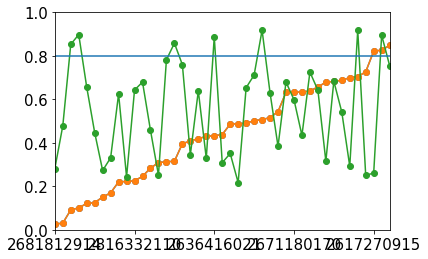

In [106]:
QC_general_tsne['frac_median_orig'].sort_values(ascending=True).plot(style='-o')
QC_general_tsne['R_median'].divide(QC_general_tsne['R_mean']).plot(style='-o')
#QC_general_tsne['frac_median_orig'].sort_values(ascending=True).plot(style='-o')
plt.ylim(0,1)
plt.axhline(.8)
plt.show()

In [137]:
#plot_all_circles_thres(tsne,QC_general_tsne,.8,maindir+'plots/','main_tSNE5mer_15feb')
plot_all_circles_thres(tsnePCA100,QC_PCA100,.8,maindir+'plots/','PCA100_tSNE5mer_15feb')

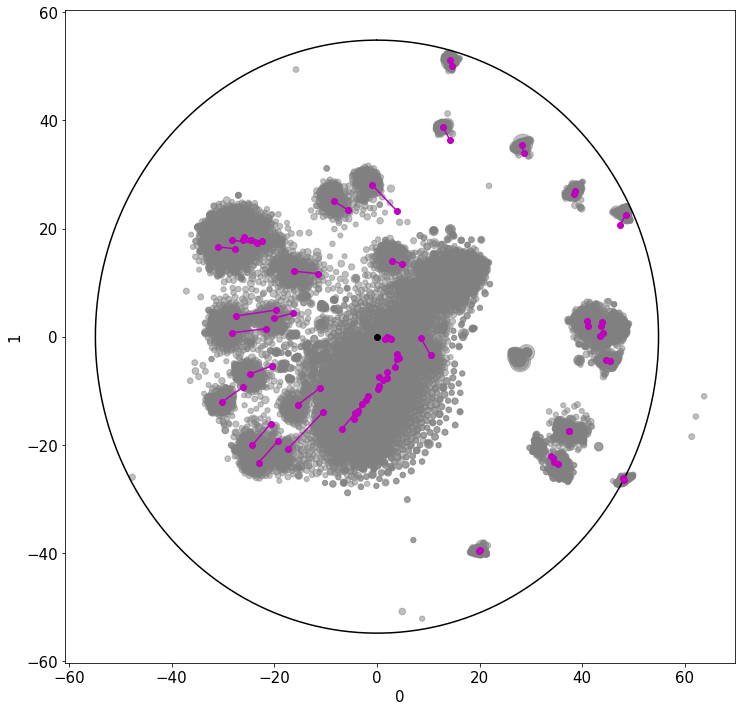

In [111]:
max_dist_from_origin = QC_general_tsne['dist_from_origin_median'].max()
cx,cy = circle(0,0,max_dist_from_origin)
f,ax = plt.subplots(figsize=(12,12))
tsne.plot.scatter(0,1,alpha=.5,s=tsne['Sequence length'].astype(float).divide(2e2),
                     c='gray',ax=ax,label=None)
plt.plot(cx,cy,'k')
plt.plot(0,0,'ok')
plt.plot([QC_general_tsne['median_x'],QC_general_tsne['mean_x']],
         [QC_general_tsne['median_y'],QC_general_tsne['mean_y']],
         '-om',label='median contig pos')
plt.show()

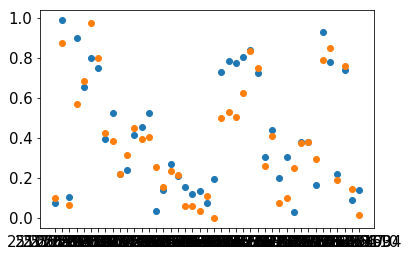

In [139]:
plt.plot(QC_general_tsne['frac_mean_orig']-QC_general_tsne['frac_med_mean_diff'],'o')
plt.plot(QC_PCA100['frac_mean_orig']-QC_PCA100['frac_med_mean_diff'],'o')
plt.show()

In [107]:
QC_PCA100

,total_distance,num_contigs,median_x,median_y,mean_x,mean_y,R_median,R_mean,mean_dist,norm_mean_dist,dist_from_origin_mean,dist_from_origin_median,frac_mean_orig,frac_median_orig
2681812914,2.00285e+06,559,-0.874332,27.984547,3.899136,23.246748,2.543268,9.039578,12.819,0.114033,23.571477,27.998202,0.364403,0.432838
2778260947,1.06691e+06,525,2.987697,14.070319,4.916651,13.380527,2.442025,5.105940,7.74177,0.0688681,14.255244,14.384026,0.220379,0.222370
2510065051,1.36944e+06,468,4.354826,-4.005238,3.916543,-3.187364,7.583966,8.892237,12.5049,0.111239,5.049614,5.916624,0.078065,0.091468
2636416047,1.23098e+06,478,1.225796,-7.981203,0.334925,-7.535625,6.505720,7.245887,10.7752,0.0958522,7.543065,8.074787,0.116612,0.124832
2642422537,207731,276,40.897270,2.931713,41.159931,1.909792,2.421487,3.687669,5.45398,0.0485167,41.204214,41.002215,0.636997,0.633874
